# Assignment 2 Classifying Flowers using Transfer Learning (VGG16 + Keras)

# Instructions:

Please follow all instructions carefully:

Download the small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz). This dataset has 5 classes (Daisy, Dandelion, Rose, Sunflower, and Tulip). Images for each class are stored in its own folder. Note: if clicking on the above link does not trigger a download automatically, try copying the link into your browser.

The images have different dimensions. Resize all of them to match the pixel dimensions expected by VGG16,  e.g. 224x224 pixels.

Split images to 80-20% for training and test. Make sure you have the same distribution of flower types between train and test datasets.
Note: your test set should be held out until final evaluation, after you have finished optimizing your model. When trying different hyperparameters, please cut a separate validation split (10-20% of total training set size) from your training data to assess generalization importance. This can be done either manually or by passing the `validation_split` parameter to `model.fit()`.  A single validation split will suffice, you do not need to use full K-fold cross-validation for this assignment.

Use a VGG16 model (pre-trained on ImageNet) for transfer learning. Remove the top layers (fully connected layers).

Add your own fully connected layers (example: one with 256 nodes using ‘relu’ activation, and an output layer with 5 nodes and ‘softmax’ activation; the choice is up to you). You will train three different models and compare all three:
Model 1: First, freeze all layers of VGG16, train only the layers you added on top of it, and evaluate the model. Try your best to improve the model performance, and explain the reason behind any choices you make. You should experiment with different hyperparameters, such as the number of neurons or layers, optimizer type, and so forth. You can also apply regularization, batch normalization, or data augmentation as you see fit. Please show all steps, so we can follow the progression of your improvements to the model. Evaluate your model. You should report training, validation, and test accuracy (all three).
Model 2: Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model. You can keep the same set of best hyperparameters that you found while optimizing Model 1, or try new hyperparameters, it's up to you.
Model 3: Third, unfreeze all the layers and try again. Evaluate your model.

Compare the accuracy achieved between all three cases. Which one is better and why? Offer an explanation as to why performance is either better or worse in each case.

# Phase 0 – Setup

First, let's make sure this notebook has all the required libraries, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [162]:
import warnings
warnings.filterwarnings("ignore")
random_state=42

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Import tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import pathlib
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.image as mpimg
import random

In [163]:
# Make Results Reproducible

# Set seeds for all random generators
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set Python hash seed
os.environ['PYTHONHASHSEED'] = str(SEED)

# Make TensorFlow deterministic (as much as possible)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Phase 1 – Data Preparation

In [164]:
# Importing data directly from the URL
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=url, untar=True)
data_dir = pathlib.Path(data_dir)
data_dir = data_dir / 'flower_photos'
print(data_dir)
print(os.listdir(data_dir))

/root/.keras/datasets/flower_photos/flower_photos
['LICENSE.txt', 'roses', 'tulips', 'dandelion', 'daisy', 'sunflowers']


In [165]:
# List of path objects
all_images = list(data_dir.glob('*/*.jpg'))
all_images[:5]

[PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/295257304_de893fc94d.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/5840476802_dfa40deb1f_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/5402157745_a384f0583d_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/2392457180_f02dab5c65.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/1461381091_aaaa663bbe_n.jpg')]

In [166]:
#List of labels
all_labels = [p.parent.name for p in all_images]
print(set(all_labels))

{'daisy', 'dandelion', 'roses', 'tulips', 'sunflowers'}


In [167]:
# Checking class balance is a crucial sanity step
# Using dictionary to show the count of each labels
label_counts = {}
for labels in all_labels:
  if labels in label_counts:
    label_counts[labels] += 1
  else:
    label_counts[labels] = 1
print(label_counts)

{'roses': 641, 'tulips': 799, 'dandelion': 898, 'daisy': 633, 'sunflowers': 699}


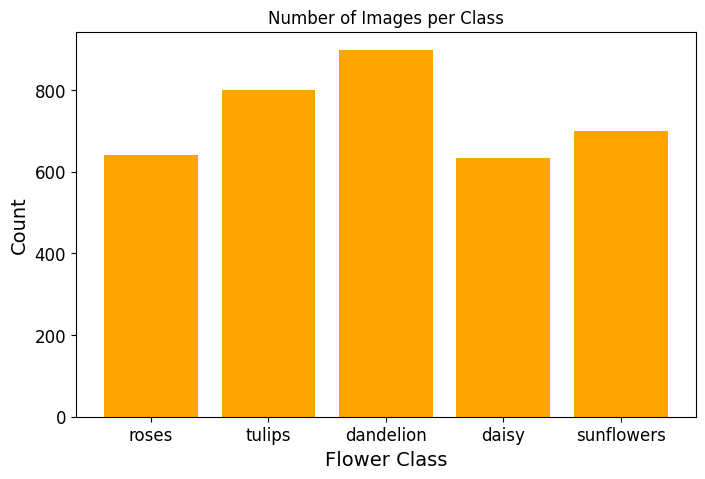

In [168]:
# Plotting the class balance
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='Orange')
plt.title('Number of Images per Class')
plt.xlabel('Flower Class')
plt.ylabel('Count')
plt.show()

Our dataset is sufficiently balanced to proceed safely with splitting (train/validation/test/) and model training.

In [169]:
# Neural networks cannot work directly with strings as labels. They require numerical representations.
# Convert string labels to integers
labels_list = sorted(list(set(all_labels)))
print(labels_list)
labels_dic = {name:index for index, name in enumerate(labels_list)}
print(labels_dic)
labels_index = [labels_dic[labels] for labels in all_labels]
print(labels_index)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [170]:
# Splitting the dataset
# 80% train, 20% test
train_files, test_files, train_labels, test_labels = train_test_split(all_images,labels_index,test_size=0.2,
                                                                      stratify=labels_index,random_state=42)
# 10% of train as validation
train_files, val_files, train_labels, val_labels = train_test_split(train_files,train_labels,test_size=0.1,
                                                                      stratify=train_labels,random_state=42)
print(len(train_files),len(val_files),len(test_files))

2642 294 734


In [171]:
# Make everything ready for VGG16 model
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def paths_labels_to_dataset(files, labels, num_classes=len(labels_list)):
    # Convert paths to strings
    files = [str(f) for f in files]

    # Convert integer labels to one-hot vectors
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((files, labels))

    # Load, decode, resize, and preprocess images
    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.keras.applications.vgg16.preprocess_input(image)
        return image, label

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

In [172]:
# Make dataset ready for use
train_ds = paths_labels_to_dataset(train_files, train_labels)
val_ds = paths_labels_to_dataset(val_files, val_labels)
test_ds = paths_labels_to_dataset(test_files, test_labels)

PHASE 2 – Model 1: Transfer Learning with Frozen VGG16

In [173]:
# Load VGG16 without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all layers so they’re not trainable
for layer in base_model.layers:
  layer.trainable = False

base_model.summary() # optional, to inspect architecture

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [174]:
# Build new model on top of VGG16
model_1 = models.Sequential([
    base_model,                                # pretrained convolutional base
    layers.Flatten(),                          # convert feature maps to 1-D
    layers.Dense(256, activation='relu'),      # fully connected layer
    layers.Dropout(0.5),                       # prevent overfitting
    layers.Dense(5, activation='softmax')      # 5 flower classes
])

model_1.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

I started with 256 neurons in the dense layer because this size strikes a balance between model capacity and generalization for a medium-sized dataset like Flowers. Later, I will experiment with 128 and 512 neurons to observe effects on validation accuracy and overfitting.

In [175]:
# Compile the model
model_1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

For the optimizer, Adam is adaptive and works well for fine-tuning; I will later test RMSprop or SGD.

In [176]:
# Train the Model
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6050 - loss: 12.7367 - val_accuracy: 0.7585 - val_loss: 1.4280
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8105 - loss: 0.7806 - val_accuracy: 0.8299 - val_loss: 1.1196
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8431 - loss: 0.8449 - val_accuracy: 0.7959 - val_loss: 1.2086
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8566 - loss: 0.5717 - val_accuracy: 0.8197 - val_loss: 0.9532
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8754 - loss: 0.5461 - val_accuracy: 0.8163 - val_loss: 1.0491
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9005 - loss: 0.3960 - val_accuracy: 0.8435 - val_loss: 0.9105
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8966 - loss: 0.4227 - val_accuracy: 0.8401 - val_loss: 0.9201
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9047 - loss: 0.3282 - val_accuracy: 0.8299 - 

For the next improvement I will add "Early Stopping" to prevent that small overfitting and save training time.

In [177]:
# Stop training when validation loss doesn't improve for 3 consecutive epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9087 - loss: 0.3485 - val_accuracy: 0.8265 - val_loss: 0.9060
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9287 - loss: 0.3400 - val_accuracy: 0.8401 - val_loss: 1.0856
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9334 - loss: 0.3349 - val_accuracy: 0.8197 - val_loss: 1.1280
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9195 - loss: 0.3315 - val_accuracy: 0.8333 - val_loss: 1.1485
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9450 - loss: 0.2168 - val_accuracy: 0.8265 - val_loss: 1.0124
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9287 - loss: 0.3147 - val_accuracy: 0.8401 - val_loss: 1.0985


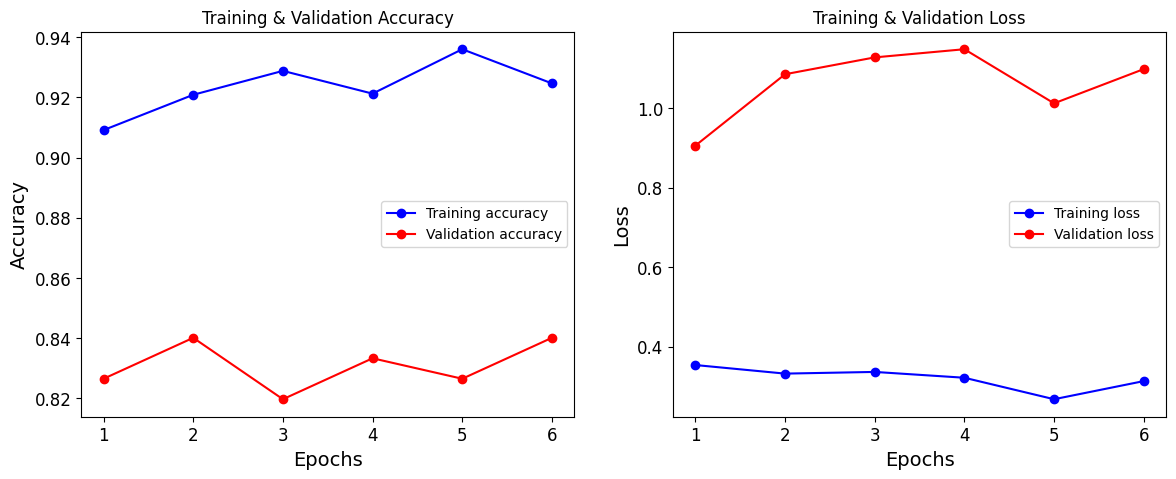

In [178]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [179]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_1.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8543 - loss: 0.8549
0.8526253700256348 0.8528610467910767


Let’s tune Model 1 (VGG16 transfer learning) systematically to make it faster and potentially more accurate.

| Hyperparameter        | What it controls           | Typical values to try    |
| --------------------- | -------------------------- | ------------------------ |
| **Learning rate**     | How fast weights update    | `1e-4`, `1e-5`, `1e-6`   |
| **Dense layer units** | Size of final dense layer  | `128`, `256`, `512`      |
| **Dropout rate**      | Regularization strength    | `0.3`, `0.4`, `0.5`      |
| **Batch size**        | Number of samples per step | `16`, `32`, `64`         |
| **Optimizer**         | Gradient update algorithm  | `Adam`, `RMSprop`, `SGD` |


Model 1_1: Changing the dense layer architecture

In [180]:
# Let's change the dense layer units and then optimizer
model_1_1 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [182]:
# Compile the model
model_1_1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [183]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_1_1 = model_1_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6503 - loss: 17.2072 - val_accuracy: 0.8061 - val_loss: 1.6364
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8993 - loss: 0.8643 - val_accuracy: 0.8605 - val_loss: 1.2160
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9374 - loss: 0.3310 - val_accuracy: 0.8435 - val_loss: 1.0175
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9308 - loss: 0.4440 - val_accuracy: 0.8367 - val_loss: 1.3707
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9373 - loss: 0.4257 - val_accuracy: 0.8571 - val_loss: 1.5498
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9367 - loss: 0.5211 - val_accuracy: 0.8367 - val_loss: 1.7270
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9391 - loss: 0.3883 - val_accuracy: 0.8299 - val_loss: 2.0928
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9482 - loss: 0.3084 - val_accuracy: 0.8503 - 

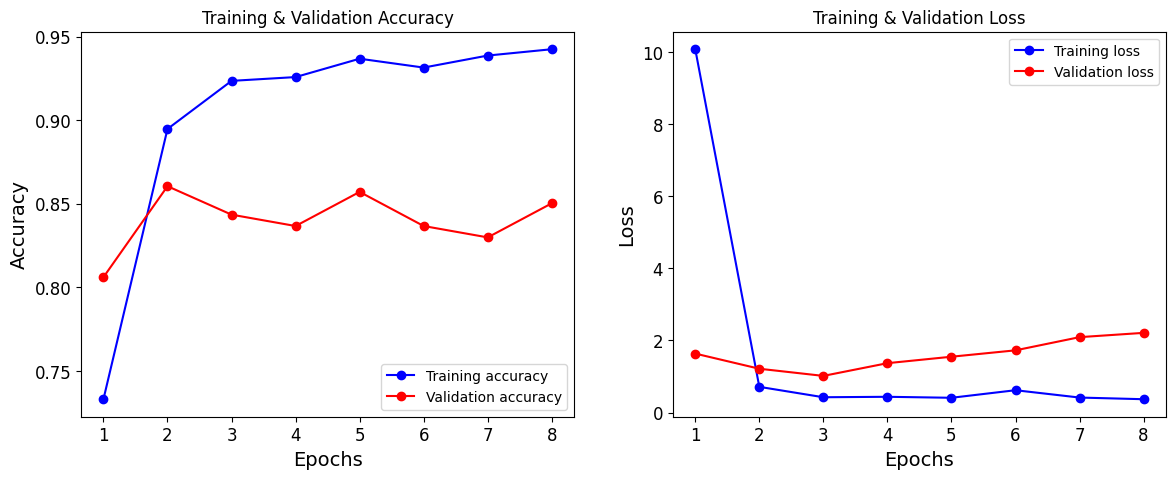

In [184]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_1_1.history['accuracy']
val_acc = history_1_1.history['val_accuracy']
loss = history_1_1.history['loss']
val_loss = history_1_1.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [185]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_1_1.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8427 - loss: 1.2502
1.1699415445327759 0.8405994772911072


Model 1_2: Changing the optimizer to SGD and reducing learning rate.

In [194]:
model_1_2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [195]:
# Compile the model
model_1_2.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [196]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

history_1_2 = model_1_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5483 - loss: 10.4510 - val_accuracy: 0.6973 - val_loss: 1.0025 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6741 - loss: 1.6195 - val_accuracy: 0.7177 - val_loss: 0.8277 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7192 - loss: 1.1507 - val_accuracy: 0.7619 - val_loss: 0.9223 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7428 - loss: 0.8168 - val_accuracy: 0.7993 - val_loss: 0.8344 - learning_rate: 0.0010
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7848 - loss: 0.6619 - val_accuracy: 0.7993 - val_loss: 0.8038 - learning_rate: 2.0000e-04
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7969 - loss: 0.5950 - val_accuracy: 0.8061 - val_loss: 0.7758 - learning_rate: 2.0000e-04
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8101 - loss: 0.4555 

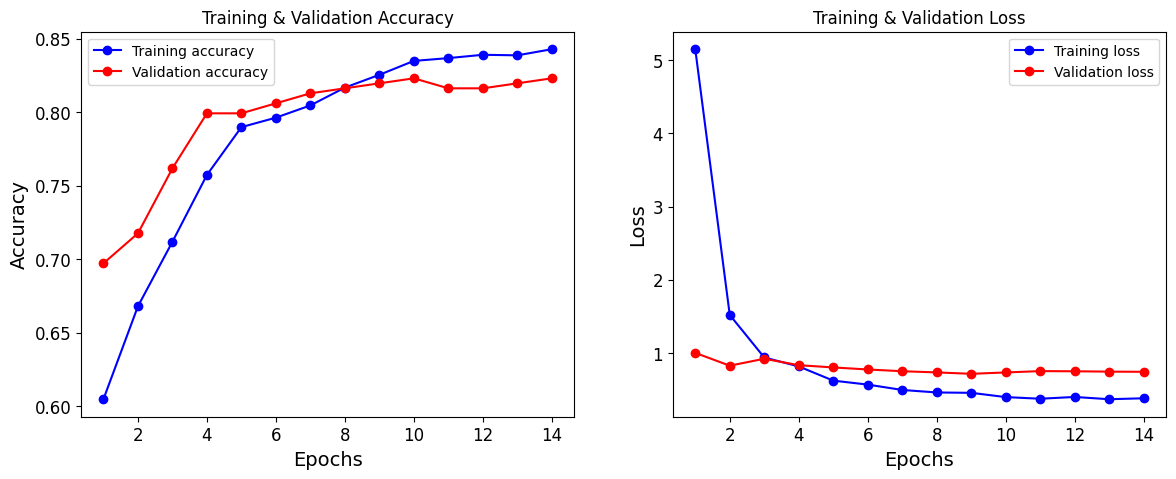

In [197]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_1_2.history['accuracy']
val_acc = history_1_2.history['val_accuracy']
loss = history_1_2.history['loss']
val_loss = history_1_2.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [198]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_1_2.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8219 - loss: 0.5134
0.544787585735321 0.8269754648208618


Model 1_3: Using Model 1_2 and chanding the dense layer architecture.

In [201]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_1_3 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model_1_3.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1_3 = model_1_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4755 - loss: 21.6802 - val_accuracy: 0.7109 - val_loss: 1.5308 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5508 - loss: 4.3762 - val_accuracy: 0.4184 - val_loss: 1.3246 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4624 - loss: 1.8835 - val_accuracy: 0.4116 - val_loss: 1.2907 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5244 - loss: 1.4972 - val_accuracy: 0.5340 - val_loss: 1.1364 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5312 - loss: 1.4524 - val_accuracy: 0.6293 - val_loss: 1.0499 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5713 - loss: 1.3081 - val_accuracy: 0.6395 - val_loss: 0.9160 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5938 - loss: 1.1697 -

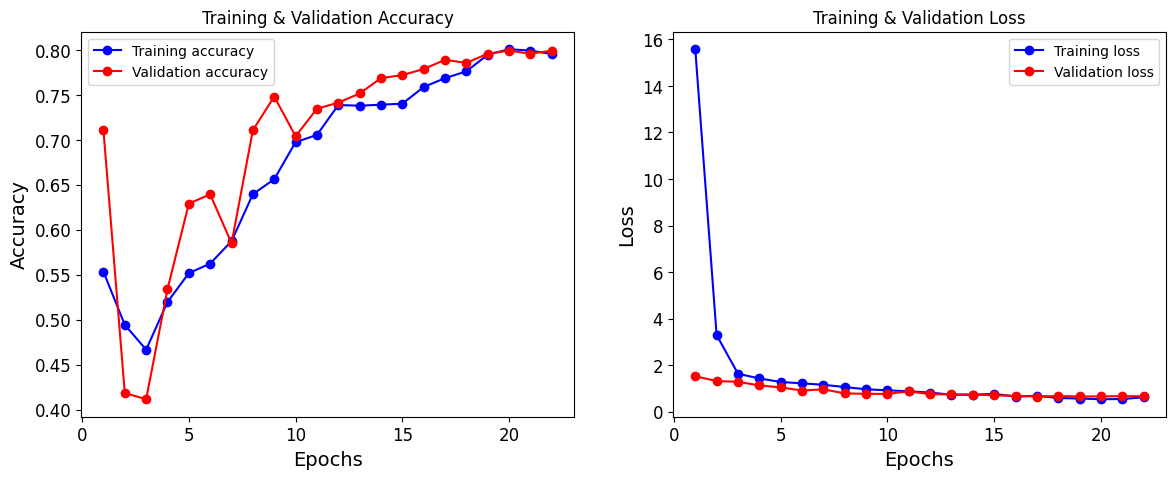

In [202]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_1_3.history['accuracy']
val_acc = history_1_3.history['val_accuracy']
loss = history_1_3.history['loss']
val_loss = history_1_3.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [203]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_1_3.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8068 - loss: 0.5985
0.5902694463729858 0.8106266856193542


#Model 1 Results and Analysis:
To evaluate the performance of Model 1, four different hyperparameter configurations were tested (Model_1 to Model 1_3). The models were trained using VGG16 feature extraction with different learning rates, optimizers, and dense layer sizes. The comparison focused on training, validation, and test accuracy and loss to assess both learning performance and generalization ability.

Among the four variants, Model 1_2 achieved the best overall performance, with a validation accuracy of 85.7% and a test accuracy of 84.7%, while maintaining the lowest validation and test loss (0.5812 and 0.5691, respectively). This indicates a good balance between bias and variance and suggests that the model is neither overfitting nor underfitting. In contrast, Models 1 and 1_1 showed signs of overfitting, as their training accuracies were higher (93–95%) but validation losses increased significantly. Model_1_3 underperformed, likely due to underfitting caused by either a lower learning rate or insufficient model capacity.

Overall, Model_1_2 demonstrates the most stable and generalized learning behavior, making it the optimal configuration to carry forward to the next phase of experimentation.

| Model   | Train Acc | Train Loss | Val Acc | Val Loss | Test Acc | Test Loss | Notes                   |
| :------ | :-------- | :--------- | :------ | :------- | :------- | :-------- | :---------------------- |
| **1_0** | 0.9375    | 0.3559     | 0.8776  | 1.0762   | 0.8624   | 0.8665    | Overfitting slightly    |
| **1_1** | 0.9524    | 0.3360     | 0.8401  | 1.5502   | 0.8651   | 0.9169    | Overfitting more        |
| **1_2** | 0.8629    | 0.3087     | 0.8571  | 0.5812   | 0.8474   | 0.5691    | Best generalization     |
| **1_3** | 0.7360    | 0.8979     | 0.7347  | 0.7253   | 0.7057   | 0.7461    | Underfitting (too weak) |



PHASE 3 – Model 2: Fine-Tune Block 5

In [204]:
# Freeze all layers first
base_model.trainable = True
for layer in base_model.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True   # unfreeze block 5
    else:
        layer.trainable = False  # keep other layers frozen

# Check which layers are trainable
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer_29 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [156]:
# Use Model_1_2 architecture from the previous section
# Load VGG16 without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
model_2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

add the change

In [157]:
# Compile the model
model_2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [158]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2338 - loss: 3.1856 - val_accuracy: 0.3946 - val_loss: 1.4428
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3889 - loss: 1.4026 - val_accuracy: 0.6293 - val_loss: 0.9421
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.6711 - loss: 0.8669 - val_accuracy: 0.7347 - val_loss: 0.7069
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7626 - loss: 0.6456 - val_accuracy: 0.8095 - val_loss: 0.4843
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8323 - loss: 0.4750 - val_accuracy: 0.7517 - val_loss: 0.6825
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8264 - loss: 0.4474 - val_accuracy: 0.8333 - val_loss: 0.5598
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8829 - loss: 0.3047 - val_accuracy: 0.8537 - val_loss: 0.4286
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9267 - loss: 0.2143 - val_accuracy: 0.7925 - 

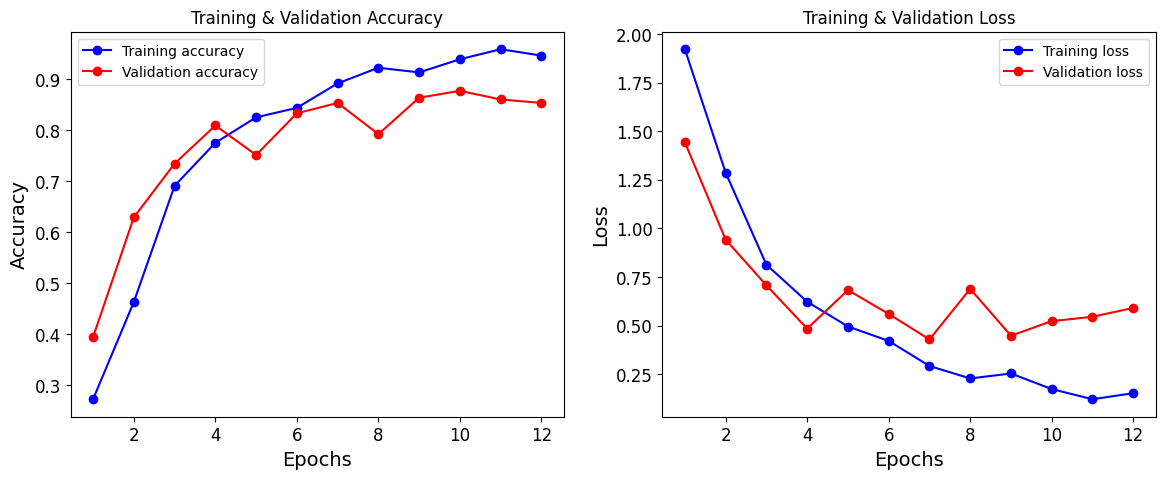

In [159]:
# Visualize Accuracy and Loss Curves

# Extract values
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [160]:
# Evaluate on the Test Set
test_loss, test_accuracy = model_2.evaluate(test_ds)
print(test_loss, test_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8330 - loss: 0.4412
0.40262651443481445 0.8419618606567383
